In [1]:
#!/usr/bin/env python

# pdf_shift.ipynb

'''
    File name: conditions_WBGT_monthmax.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Needs data from:
    papers/2024/2024_WBGT_Climate-Change/programs/city_analysis/city_analysis.py
    papers/2024/2024_WBGT_Climate-Change/programs/conditions_WBGT/conditions_WBGT_monthmax-warming-targets.py
    
    Purpose:

    1) Read in preprocessed WBGT PDFs for cities
    2) Show whats happening when the pdf moves rightward

'''

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import random

import warnings
warnings.filterwarnings("ignore")

In [3]:
def solar_time_difference_from_utc(longitude):
    from datetime import datetime, timedelta, timezone
    """
    Calculate the difference between local solar time and UTC based on the given longitude.

    Args:
    - longitude (float): The longitude of the location in degrees (East is positive, West is negative).

    Returns:
    - time_difference (timedelta): The difference from UTC as a timedelta object.
    """
    # Calculate the time difference due to longitude (in minutes)
    time_difference_minutes = longitude * 4  # 4 minutes per degree

    # Create a timedelta object for the time difference
    time_difference = timedelta(minutes=time_difference_minutes)
    
    return time_difference

### User imput section

In [4]:
data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/WBGT_monmax_variables/'
city_data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_changes/'
save_dir_base = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_analysis/'

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2021, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2011, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)

In [5]:
cities = ['Phoenix',
          'Miami',
          'New Orleans',
          'Houston',
          'Atlanta',
          'DC',
          # 'Yuma',
          'Sacramento',
          'Dalas',
          'Charlotte',
          'Chicago',
          'New York City',
          'Tampa',
            ]
city_loc = [
            [[350,370],[370,390]],
            [[1120,1135],[170,225]],
            [[860,880],[255,265]],
            [[730,760],[240,270]],
            [[980,1000],[373,400]],
            [[1110,1135],[540,575]],
            # [[292,300],[365,370]],
            [[180,195],[550,570]],
            [[685,720],[325,350]],
            [[1055,1070],[430,450]],
            [[875,900],[580,610]],
            [[1160,1180],[600,635]],
            [[1055,1070],[230,240]],
           ]

temp_channge = np.arange(0,3.1,0.1)
delta_t = 0.25
minyears = 7

### Load global average LENS2 temperature for warming level selection

In [6]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.25 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2022,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])

pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

In [7]:
warming_tar = 0.25
targ_ref = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 1
targ_1C = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 2
targ_2C = years_pgw[(pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)]

# Read CONUS404 CTR OR PGW WBGT DATA

In [8]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [9]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()



### Calculate and save histograms

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

cities_sel = ['Phoenix',
              'Miami',
              'Chicago',
              'New York City',
              'Sacramento'
            ]

urb_cat = ["urban","rural"]
climates = ["baseline", "1C", "2C"]
custom_bin_edges = np.arange(-40,50,0.1)

hist_citys = np.zeros((len(cities_sel), len(climates), len(custom_bin_edges)-1)); bin_cent[:] = np.nan

for cc in tqdm(range(len(cities_sel))):
    city = cities_sel[cc]
    cy = cities.index(city)
    save_dir = save_dir_base + city + '/'
    LU_city = LU[city_loc[cy][1][0]:city_loc[cy][1][1],
             city_loc[cy][0][0]:city_loc[cy][0][1]]
    
    # # ================================================
    # # Load data
    data_ctr = xr.open_dataset(save_dir+"/CONUS404_ctr_"+cities[cy]+"_statistics.nc")
    time_ctr = pd.to_datetime(data_ctr.time.values)
    lat = data_ctr.latitude.values
    lon = data_ctr.longitude.values
    wcrp_ctr = data_ctr.WBGT.values
    
    # load PGW data
    data_pgw = xr.open_dataset(save_dir+"/CONUS404_pgw_"+cities[cy]+"_statistics.nc")
    time_pgw = pd.to_datetime(data_pgw.time.values)
    lat = data_pgw.latitude.values
    lon = data_pgw.longitude.values
    wcrp_pgw = data_pgw.WBGT.values
    
    
    # # ================================================
    # # Histogram plots    
    
    # historic climate
    time_foc = np.in1d(time_c404_ctr.year, targ_ref)
    normalize = len(targ_ref) * np.sum(LU_city.values == 13)
    data_act = (wcrp_ctr[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    hist_citys[cc,0,:], bin_edges = np.histogram(data_act, bins=custom_bin_edges, density=True)

    # 1C climate
    time_foc = np.in1d(time_c404_ctr.year, targ_1C)
    normalize = len(targ_1C) * np.sum(LU_city.values == 13)
    data_act = (wcrp_ctr[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    hist_citys[cc,1,:], bin_edges = np.histogram(data_act, bins=custom_bin_edges, density=True)

    # historic climate
    time_foc = np.in1d(time_c404_pgw.year, targ_2C)
    normalize = len(targ_2C) * np.sum(LU_city.values == 13)
    data_act = (wcrp_pgw[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    hist_citys[cc,2,:], bin_edges = np.histogram(data_act, bins=custom_bin_edges, density=True)

bin_cent = (custom_bin_edges[:-1]+custom_bin_edges[1:])/2
    

100%|██████████| 5/5 [03:44<00:00, 44.94s/it]


In [83]:
# https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
def add_subplot_axes(ax,rect):#,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

100%|██████████| 4/4 [00:00<00:00, 14.56it/s]
mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: PDF_shift.pdf


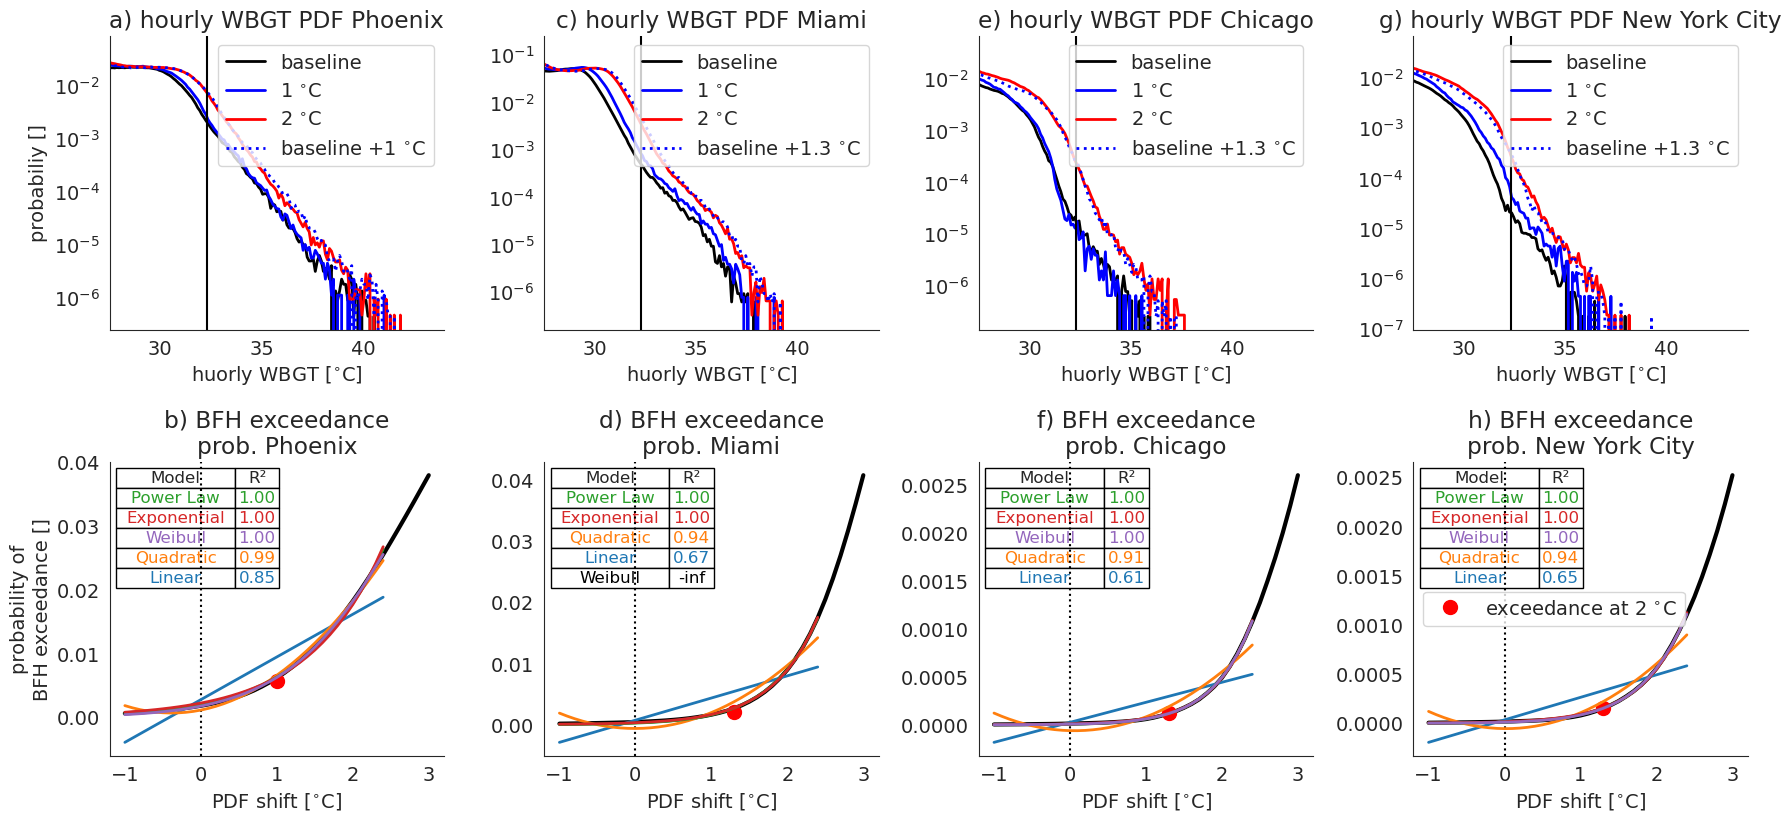

In [114]:
import string
import warnings
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")
climates = ["baseline", "1 $^{\circ}$C", "2 $^{\circ}$C"]

plt.rcParams.update({'font.size': 14})
abc_array = list(string.ascii_lowercase) + list(string.ascii_uppercase)

fig = plt.figure(figsize=(18,8))
gs1 = gridspec.GridSpec(2,len(cities_sel)-1) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.07, top=0.97,
           wspace=0.3, hspace=0.45)

city_shift = [1,1.3,1.3,1.3]
for cc in tqdm(range(len(cities_sel)-1)):
    ax = plt.subplot(gs1[0,cc])
    city = cities_sel[cc]
    cy = cities.index(city)

    plt.plot(bin_cent, hist_citys[cc,0,:],
            label = climates[0],
            color="k",
            lw=2)
    plt.plot(bin_cent, hist_citys[cc,1,:],
            label = climates[1],
            color="b",
            lw=2)
    plt.plot(bin_cent, hist_citys[cc,2,:],
            label = climates[2],
            color="r",
            lw=2)

    # plot the shifted baseline pdf
    plt.plot(bin_cent, 
             np.roll(hist_citys[cc,0,:],int(city_shift[cc]*10)),
             label = climates[0]+" +"+str(city_shift[cc])+" $^{\circ}$C",
             color="b",
             lw=2,
             ls=":")
    
    ax.set_xlim([27.5, 44])
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if cc == 0:
        plt.ylabel('probabiliy []')
    plt.xlabel('huorly WBGT [$^{\circ}$C]')
    
    #plt.axvline(x=26.6667, c = '#33a02c', ls = ':')
    #plt.axvline(x=29.4444, c = '#ffed6f', ls = ':')
    #plt.axvline(x=31.1111, c = '#e31a1c', ls = ':')
    plt.axvline(x=32.3, c = 'k', ls = '-')

    plt.legend() 
    # Customize the plot as needed
    ax.set_title(abc_array[cc*2]+') hourly WBGT PDF '+cities[cy])

    # ==========================================================
    ### plot the increase in BFH when right-shifting baseline PDF
    ax = plt.subplot(gs1[1,cc])

    shift = np.arange(-1,3.1,0.1)
    bfh_count = np.zeros((len(shift))); bfh_count[:] = np.nan
    for sh in range(len(bfh_count)):
        above_bf = np.where(bin_cent + shift[sh] > 32.3)[0][0]
        bfh_count[sh] = np.sum(hist_citys[cc,0,above_bf:])*0.1
    plt.plot(shift, bfh_count,
            c="k",
            lw=3)
    above_bf = np.where(bin_cent + 0 > 32.3)[0][0]
    plt.plot(city_shift[cc], 
             np.sum(hist_citys[cc,2,above_bf:])*0.1,
             color ="r",
             marker = "o",
             markersize = 10,
             label = "exceedance at 2 $^{\circ}$C",
             lw=0
            )
    
    # ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('PDF shift [$^{\circ}$C]')
    if cc == 0:
        plt.ylabel('probability of\nBFH exceedance []')
    plt.axvline(x=0, c = 'k', ls = ':')

    if cc == 3:
        plt.legend(loc='center left') 
    ax.set_title(abc_array[cc*2+1]+') BFH exceedance\nprob. '+cities[cy])

    # functional fit estimate
    x_data = shift[:35] + 10
    y_data = bfh_count[:35]
    
    # Define different models
    def linear(x, a, b):
        return a * x + b
    
    def quadratic(x, a, b, c):
        return a * x**2 + b * x + c
    
    def power_law(x, a, n):
        return a * x**n
    
    def exponential(x, a, b):
        return a * np.exp(b * x)
    
    def weibull(x, a, b, c):
        return a * (c / b) * (x / b)**(c - 1) * np.exp(-(x / b)**c)
    
    
    # Compute initial slope and intercept for power-law fitting
    # Avoid log issues by filtering out non-positive values for power-law fitting
    valid = (x_data > 0) & (y_data > 0)
    log_x = np.log(x_data[valid])
    log_y = np.log(y_data[valid])
    if len(log_x) > 1 and len(log_y) > 1:
        n_init, log_a_init = np.polyfit(log_x, log_y, 1)
        a_init = np.exp(log_a_init)
    else:
        a_init, n_init = 1, 1  # Fallback if log transformation fails

    # get better starting estimates for quadratic function
    X = np.vstack((x_data**2, x_data, np.ones_like(x_data))).T  # Design matrix
    params, _, _, _ = np.linalg.lstsq(X, y_data, rcond=None)  # Least squares regression


    # Fit models
    models = {
        "Linear": (linear, [1, 1]),
        "Quadratic": (quadratic, params),
        "Power Law": (power_law, [a_init, n_init]),
        "Exponential": (exponential, [1, 1]),
        "Weibull": (weibull, [max(y_data), np.mean(x_data), 1.5])
    }
    
    results = {}
    
    for name, (func, p0) in models.items():
        try:
            popt, _ = curve_fit(func, x_data, y_data, p0=p0, maxfev=5000)
            y_pred = func(x_data, *popt)
            r2 = r2_score(y_data[~np.isnan(y_pred)], y_pred[~np.isnan(y_pred)])
            results[name] = (popt, round(r2, 2))  # Round R² to 2 decimal places
        except RuntimeError:
            results[name] = (None, -np.inf)  # Failed fit
    
    # Sort results by best R² score
    sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(
        [(name, r2) for name, (_, r2) in sorted_results],
        columns=["Model", "R² Score"]
    )
    
    # Store colors for table text
    line_colors = {}
    
    for name, (func, _) in models.items():
        if results[name][0] is not None:  # Only plot successful fits
            popt, _ = curve_fit(func, x_data, y_data, p0=models[name][1], maxfev=5000)
            line, = ax.plot(x_data-10, func(x_data, *popt), label=name, lw=2)  # Capture line color
            line_colors[name] = line.get_color()  # Save color
        
    # Create inset table with R² values and color the text accordingly
    table_data = [[f"{name}", f"{r2:.2f}"] for name, (_, r2) in sorted_results]
    table = ax.table(cellText=table_data, colLabels=["Model", "R²"], cellLoc='center', loc='upper left')
    
    # Adjust column width, scale, and font size
    table.auto_set_column_width([0, 1])
    table.scale(1.5, 1.2)  # Increase table size further
    for key, cell in table.get_celld().items():
        cell.set_fontsize(12)  # Set very large font size
    
    # Apply colors to table text
    for i, (name, _) in enumerate(sorted_results):
        for j in range(2):  # Apply color to both columns (Model & R²)
            cell = table[i + 1, j]  # Row starts at 1 (header is 0)
            cell.set_text_props(color=line_colors.get(name, "black"))  # Default to black if missing
        

sPlotFile=""
sPlotName= 'PDF_shift.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

In [102]:
params

array([ 9.49775143e-05, -1.86856361e-03,  9.17487325e-03])

In [ ]:
stop()

In [ ]:
pgw_data = np.zeros((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1])); pgw_data[:] = np.nan
pgw_time = np.empty((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1]), dtype='datetime64[s]')

In [ ]:
for yy in tqdm(range(len(years_pgw))):
    for mm in range(12):
        datafile = data_dir + str(years_pgw[yy]) + str(mm+1).zfill(2) +'_WBGT_monmax_variables_pgw.npz'
        if os.path.isfile(datafile) == True:
            data = np.load(datafile)
            pgw_data[yy,mm,:,:] = data['conus_ctr'][:,:,0]
            pgw_time[yy,mm,:] = data['timestamp_max']

In [ ]:
month_max = np.nanargmax(ctr_data[:,:,:,:], axis=1)
y,la,lo = np.indices(ctr_data[:,0,:,:].shape)

ymax_ctr = np.copy(ctr_data[:,0,:,:]); ymax_ctr[:]=np.nan
ymax_ctr[:,:,:] = ctr_data[y, month_max, la, lo]
ytime_ctr = ctr_time[y, month_max, la, lo]

In [ ]:
month_max = np.nanargmax(pgw_data[:,:,:,:], axis=1)
y,la,lo = np.indices(pgw_data[:,0,:,:].shape)

ymax_pgw = np.copy(pgw_data[:,0,:,:]); ymax_pgw[:]=np.nan
ymax_pgw[:,:,:] = pgw_data[y, month_max, la, lo]
ytime_pgw = pgw_time[y, month_max, la, lo]

In [ ]:
plt.plot(np.nanmean(np.nanmax(pgw_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15, c='r')
plt.plot(np.nanmean(np.nanmax(ctr_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15, c='b')

plt.show()
# plt.plot(c_pgw_years, np.nanmean(conus_pgw_wbgt, axis=(1,2))-273.15, c='r')

In [ ]:
fut = np.nanmean(np.nanmax(pgw_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15
cur = np.nanmean(np.nanmax(ctr_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15
plt.plot(fut - cur[:len(fut)], c='k')
plt.show()

### Load hourly data over city and derive statistics

In [ ]:
datasets = ['CONUS404_ctr', 'CONUS404_pgw']
flag_thresholds = [29, 31, 32]

lat_cy = lat_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                   city_loc[cy][0][0]:city_loc[cy][0][1]]
lon_cy = lon_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                   city_loc[cy][0][0]:city_loc[cy][0][1]]

In [ ]:
for da in [1]: #range(len(datasets)):
    print('WORK ON '+datasets[da])
    outfile = save_dir + datasets[da] + '_'+city+'_statistics.nc'
    if os.path.isfile(outfile) == False:
        if datasets[da] == 'CONUS404_ctr':
            data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/GWBT/'
            time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                                  end=datetime.datetime(2022, 12, 31, 23), freq='h')
            data_cy = np.zeros((len(time), lat_cy.shape[0], lat_cy.shape[1]))
            years = np.unique(time.year)
            for yy in tqdm(range(len(years))):
                for mm in range(12):
                    time_act = (years[yy] == time.year) & (mm+1 == time.month)
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_cy[time_act,:] = np.array(np.squeeze(ncid.variables['GWBT'][:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                                                             city_loc[cy][0][0]:city_loc[cy][0][1]]))
                    ncid.close()
    
        elif datasets[da] == 'CONUS404_pgw':
            data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/'
            time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                                  end=datetime.datetime(2011, 12, 31, 23), freq='h')
            data_cy = np.zeros((len(time), lat_cy.shape[0], lat_cy.shape[1]))
            years = np.unique(time.year)
            for yy in tqdm(range(len(years))):
                for mm in range(12):
                    time_act = (years[yy] == time.year) & (mm+1 == time.month)
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_cy[time_act,:] = np.array(np.squeeze(ncid.variables['__xarray_dataarray_variable__'][:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                                                             city_loc[cy][0][0]:city_loc[cy][0][1]]))
                    ncid.close()
    
                

    ds = xr.Dataset(
        {
            "WBGT": (["time", "y", "x"], data_cy)
        },
        coords={
            "time": time,
            "y": np.arange(lat_cy.shape[0]),
            "x": np.arange(lat_cy.shape[1]),
            "latitude": (["y", "x"], lat_cy),
            "longitude": (["y", "x"], lon_cy)
        }
    )
    
    # Set attributes (optional but recommended)
    ds.attrs['long_name'] = 'Wet bulb globe temperature dimensions time, latitude, longitude'
    ds['WBGT'].attrs['units'] = 'K'
    
    # Write to a NetCDF file
    ds.to_netcdf(outfile)
    
    print(f"Data successfully written to {outfile}")